# Predict volume from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [81]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')

preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [82]:
def tree_pcts(row):
    return [row.v_ma/row.v, row.v_ku/row.v, row.v_lp/row.v]

In [83]:
preprocessor.train_val_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = preprocessor.train_val_df.apply(lambda row: tree_pcts(row), 
                                                                                                  axis=1, result_type='expand')

In [85]:
preprocessor.test_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = preprocessor.test_df.apply(lambda row: tree_pcts(row), 
                                                                                                  axis=1, result_type='expand')

In [86]:
preprocessor.train_val_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,...,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid,rel_v_ma,rel_v_ku,rel_v_lp
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,...,2013-07-11,C,NaN,NaN,NaN,77,0,0.148862,0.082378,0.768760
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,...,2013-07-11,C,NaN,NaN,NaN,2,0,0.976027,0.000000,0.023973
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,...,2013-07-11,C,NaN,NaN,NaN,8,0,0.581760,0.340057,0.078142
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,...,2013-07-11,C,NaN,NaN,NaN,24,0,0.224408,0.536431,0.239161
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,...,2013-07-11,C,NaN,NaN,NaN,0,0,0.855440,0.144560,0.000000


In [134]:
trainval_tb, test_tb = preprocessor.preprocess_image(target_col=['rel_v_ku'], path=data_path/'AV_tif',
                                                     mask_plot=True,
                                                     #min_h=1.5,
                                                     normalize=True,
                                                     log_y=False)

100%|██████████| 225/225 [00:01<00:00, 177.92it/s]


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [135]:
dls = trainval_tb.dataloaders(bs=64, y_block=CategoryBlock)

Check the distribution of the target variable `v`, in order to get limits for `sigmoid_range`.

In [136]:
trainval_tb.train.y.describe()

count    1044.000000
mean        0.181619
std         0.267724
min         0.000000
25%         0.000000
50%         0.034944
75%         0.259585
max         1.000000
Name: rel_v_ku, dtype: float64

In [137]:
trainval_tb.valid.y.describe()

count    225.000000
mean       0.167017
std        0.253934
min        0.000000
25%        0.000000
50%        0.035067
75%        0.207746
max        1.000000
Name: rel_v_ku, dtype: float64

In [138]:
test_tb.train.y.describe()

count    225.000000
mean       0.156236
std        0.244777
min        0.000000
25%        0.000000
50%        0.024285
75%        0.229972
max        1.000000
Name: rel_v_ku, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 1000 m³ as the maximum value for the total volume.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [139]:
learn = tabular_learner(dls, 
                        metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  
                        y_range=(0,1)#trainval_tb.train.y.max()*1.1)
                       )
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 40'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 40              80         True      
________________________________________________________________
BatchNorm1d          64 x 40              80         True      
________________________________________________________________
Linear               64 x 200             8,000      True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

Find learning rate to use.

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.0030199517495930195)

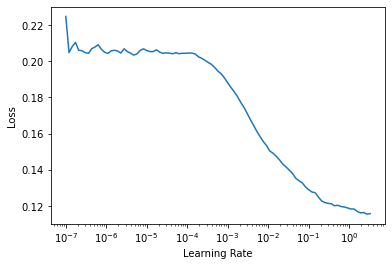

In [140]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.194979,0.181591,0.426136,255.145126,0.345252,206.716766,0.401994,-1.828713,00:00
1,0.170781,0.125736,0.354593,212.309601,0.268271,160.625000,0.333553,-0.958635,00:00
2,0.136146,0.068532,0.261786,156.742447,0.129412,77.484406,0.227439,-0.067548,00:00
3,0.107039,0.047486,0.217913,130.473557,0.050807,30.420147,0.163996,0.260294,00:00
4,0.087770,0.043260,0.207989,124.531868,0.020229,12.111822,0.148112,0.326131,00:00
5,0.075309,0.043704,0.209055,125.170151,0.032183,19.269579,0.148392,0.319206,00:00
6,0.066336,0.043618,0.208848,125.046135,0.028145,16.851847,0.149052,0.320554,00:00
7,0.060100,0.044497,0.210944,126.300903,0.010313,6.174788,0.149818,0.306850,00:00
8,0.055601,0.044788,0.211632,126.712837,0.022794,13.647993,0.148317,0.302321,00:00
9,0.052113,0.044359,0.210615,126.103973,0.010734,6.426799,0.145950,0.309010,00:00


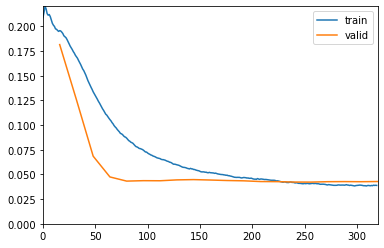

In [141]:
learn.fit_one_cycle(20, max_lr=1e-3, cbs=ShowGraphCallback())

See validation results

In [142]:
learn.validate()

(#7) [0.042841289192438126,0.206981360912323,123.92839050292969,0.01612604409456253,9.655336380004883,0.14513690769672394,0.33264659138687525]

In [143]:
preds, true = learn.get_preds()

`RegressionInterpretation` can be used to plot results.

In [144]:
preds.shape

torch.Size([225, 1])

In [145]:
reg_interp = RegressionInterpretation.from_learner(learn, dl=learn.dls[1])

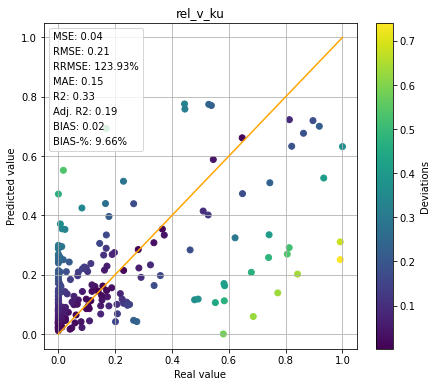

In [146]:
reg_interp.plot_results(log_y=False)
plt.show()

Evaluate test set.

In [147]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [148]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

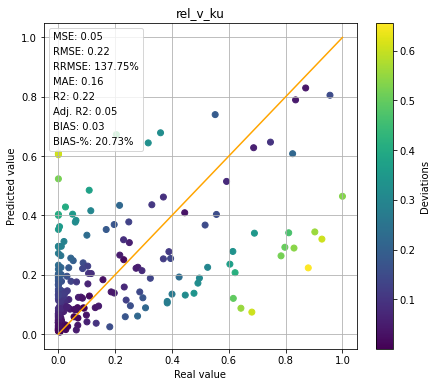

In [149]:
test_interp.plot_results(log_y=False)
plt.show()

In [150]:
test_preds = learn.get_preds(dl=test_dls.train)

In [151]:
test_preds[0].shape

torch.Size([225, 1])

In [153]:
test_v_lp = preprocessor.test_df.v_ku
pred_v_lp = preprocessor.test_df.v * test_preds[0][:,0].numpy()

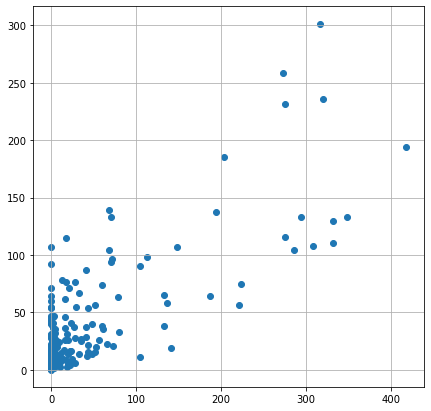

In [154]:
fig = plt.figure(figsize=(7,7))
plt.scatter(test_v_lp, pred_v_lp)
plt.grid()

# Ensemble of ANNs

Fit several models at once.

In [58]:
ensemble = Ensemble(dls, learn_func=tabular_learner, ens_dir='ensemble_test',
                    y_range=(0,trainval_tb.y.max() * 1.1), 
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], 
                    n_models=10)

In [59]:
ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,39216.835938,37539.101562,193.750107,890.927002,188.057739,864.751648,190.382309,-21.385509,00:00
1,33150.187500,23507.908203,153.322891,705.029358,145.807999,670.473389,149.038666,-13.018355,00:00
2,24263.283203,7521.577637,86.727028,398.799530,71.180214,327.310150,77.472809,-3.485305,00:00
3,16264.441406,2557.092285,50.567699,232.526993,25.721518,118.276047,37.169868,-0.524858,00:00
4,11001.412109,2143.248535,46.295231,212.880783,14.585671,67.069740,26.758070,-0.278073,00:00
5,7647.080078,2062.150391,45.410908,208.814362,9.947282,45.740891,22.789515,-0.229712,00:00
6,5440.531738,2061.166504,45.400070,208.764526,8.092003,37.209705,21.193686,-0.229125,00:00
7,3945.918945,2030.451782,45.060535,207.203247,7.099761,32.647049,20.069269,-0.210809,00:00
8,2914.310547,2008.105713,44.811890,206.059891,5.557186,25.553778,18.975023,-0.197484,00:00
9,2176.345703,2006.332520,44.792103,205.968903,5.618511,25.835770,18.520929,-0.196426,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,30509.726562,32578.171875,180.494247,829.972290,172.740936,794.319946,176.181107,-18.427179,00:00
1,25443.753906,17979.833984,134.088898,616.585083,121.760887,559.896851,127.335571,-9.721825,00:00
2,18073.490234,5149.253906,71.758301,329.968384,50.041401,230.106903,59.786713,-2.070629,00:00
3,12029.551758,1995.571289,44.671818,205.415802,16.536180,76.038826,30.389853,-0.190009,00:00
4,8175.011719,1373.994019,37.067425,170.448273,11.439376,52.602036,22.795074,0.180653,00:00
5,5706.633789,1199.944702,34.640217,159.287170,7.292377,33.532761,19.355295,0.284443,00:00
6,4084.742432,1175.000122,34.278278,157.622864,6.793619,31.239307,18.002081,0.299318,00:00
7,2986.427002,1145.710815,33.848351,155.645905,4.277994,19.671631,16.946302,0.316784,00:00
8,2216.913330,1094.334961,33.080730,152.116135,4.245441,19.521942,16.615015,0.347421,00:00
9,1678.163818,1112.917725,33.360420,153.402252,3.686311,16.950878,16.030767,0.336339,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,50221.503906,44071.812500,209.932877,965.340820,205.288467,943.984314,206.674438,-25.281126,00:00
1,42848.312500,29343.582031,171.299683,787.692566,164.795029,757.781982,167.206650,-16.498314,00:00
2,31716.621094,9754.254883,98.763618,454.147766,83.020142,381.754028,88.942398,-4.816706,00:00
3,21495.150391,3229.606934,56.829632,261.321411,31.876186,146.577240,43.261208,-0.925895,00:00
4,14635.137695,2620.849365,51.194229,235.407990,16.490133,75.827087,30.311029,-0.562878,00:00
5,10181.774414,2292.212158,47.877056,220.154526,12.202812,56.112568,25.829132,-0.366904,00:00
6,7231.076660,2160.224121,46.478214,213.722198,9.764392,44.899902,23.419861,-0.288196,00:00
7,5231.029297,2070.750732,45.505501,209.249329,9.707511,44.638344,22.036276,-0.234841,00:00
8,3835.470215,2024.388306,44.993210,206.893661,7.322857,33.672920,20.866228,-0.207194,00:00
9,2844.256836,1984.241699,44.544827,204.831833,5.829125,26.804245,19.978952,-0.183253,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,36964.523438,36551.589844,191.184708,879.130432,185.886597,854.768066,187.873093,-20.796628,00:00
1,30771.457031,20388.068359,142.786774,656.580811,134.381088,617.928650,137.544312,-11.157916,00:00
2,22039.798828,6489.184570,80.555473,370.420685,59.011051,271.352325,67.866219,-2.869663,00:00
3,14697.305664,2520.225342,50.201843,230.844666,19.502352,89.678261,35.199253,-0.502873,00:00
4,9983.858398,2573.959473,50.734207,233.292648,12.419525,57.109081,27.699877,-0.534917,00:00
5,6970.212891,2324.798096,48.216164,221.713852,9.908502,45.562565,24.213669,-0.386336,00:00
6,4969.430176,2156.926758,46.442722,213.558990,7.506735,34.518448,21.808928,-0.286229,00:00
7,3618.099854,2111.742676,45.953701,211.310318,7.424654,34.141018,20.855518,-0.259285,00:00
8,2681.621582,2055.930176,45.342365,208.499191,6.165905,28.352873,19.948071,-0.226003,00:00
9,2022.953003,2022.840332,44.975994,206.814484,4.404738,20.254440,19.287706,-0.206270,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,46155.531250,43894.785156,209.510818,963.399963,205.165604,943.419312,207.167603,-25.175562,00:00
1,39500.226562,28117.279297,167.682083,771.057678,160.797302,739.399170,163.576355,-15.767039,00:00
2,29124.447266,8931.311523,94.505623,434.568115,78.196030,359.571198,84.088593,-4.325965,00:00
3,19587.333984,2801.209229,52.926449,243.373291,27.456778,126.255341,38.673904,-0.670431,00:00
4,13257.103516,2445.266846,49.449638,227.385788,15.726963,72.317772,28.437151,-0.458174,00:00
5,9209.006836,2263.788086,47.579281,218.785263,10.696250,49.184895,24.170156,-0.349954,00:00
6,6537.906250,2188.686523,46.783401,215.125534,9.033408,41.538597,21.924068,-0.305169,00:00
7,4728.851562,2127.667725,46.126648,212.105591,6.980330,32.097866,20.656677,-0.268782,00:00
8,3482.870361,2125.882812,46.107296,212.016586,7.202188,33.118038,19.926785,-0.267717,00:00
9,2595.020752,2085.379395,45.665951,209.987137,5.836107,26.836349,19.301174,-0.243564,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,32921.199219,33108.730469,181.958038,836.703186,177.818283,817.667236,179.142639,-18.743566,00:00
1,27319.238281,17972.730469,134.062408,616.463257,127.420052,585.919495,130.027313,-9.717590,00:00
2,19392.472656,5178.653809,71.962868,330.909058,55.966286,257.351471,62.641533,-2.088161,00:00
3,12901.678711,1828.500610,42.760971,196.629089,20.683620,95.110123,30.652136,-0.090381,00:00
4,8751.643555,1251.715332,35.379589,162.687057,10.932955,50.273342,22.769024,0.253571,00:00
5,6121.158691,1127.451782,33.577549,154.400665,8.430307,38.765343,20.325144,0.327672,00:00
6,4378.191406,1121.430542,33.487766,153.987823,7.982913,36.708073,19.000507,0.331263,00:00
7,3196.706543,1057.459839,32.518608,149.531311,6.260474,28.787731,17.656082,0.369410,00:00
8,2360.965088,1036.050049,32.187733,148.009842,4.805292,22.096321,16.947178,0.382177,00:00
9,1786.171875,1035.033936,32.171947,147.937256,3.116862,14.332363,16.510815,0.382783,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,37973.285156,36921.511719,192.149734,883.567993,187.907043,864.058716,189.503510,-21.017225,00:00
1,31962.613281,21504.466797,146.644028,674.317749,139.314911,640.616028,141.975311,-11.823653,00:00
2,22981.525391,6533.051758,80.827293,371.670624,62.202805,286.029053,69.581963,-2.895822,00:00
3,15360.578125,2349.883057,48.475590,222.906784,21.567783,99.175797,34.813351,-0.401294,00:00
4,10403.666016,2090.579102,45.722847,210.248749,11.789961,54.214138,25.841784,-0.246665,00:00
5,7237.407227,2056.426514,45.347843,208.524368,9.911234,45.575130,22.456137,-0.226299,00:00
6,5164.054199,2024.431885,44.993683,206.895828,7.009261,32.230900,20.453903,-0.207219,00:00
7,3742.229980,1959.245850,44.263367,203.537582,6.324612,29.082657,19.489952,-0.168347,00:00
8,2756.682861,1946.704590,44.121475,202.885132,6.459930,29.704895,19.007399,-0.160869,00:00
9,2060.115234,1917.487549,43.789127,201.356888,5.284299,24.298952,18.213774,-0.143446,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,42707.691406,41671.554688,204.136108,938.685303,199.913055,919.266296,201.418976,-23.849792,00:00
1,36137.894531,24440.441406,156.334381,718.877197,148.598038,683.302917,150.702332,-13.574447,00:00
2,26348.847656,7485.061523,86.516251,397.830322,67.713074,311.367126,75.275238,-3.463530,00:00
3,17689.052734,2403.691162,49.027454,225.444443,24.127882,110.947975,36.175236,-0.433381,00:00
4,11973.515625,1443.830078,37.997768,174.726303,11.954477,54.970638,24.858345,0.139008,00:00
5,8324.588867,1599.935181,39.999191,183.929504,9.345075,42.971741,21.677149,0.045919,00:00
6,5921.417480,1637.118042,40.461319,186.054535,7.458046,34.294559,19.953745,0.023745,00:00
7,4298.352539,1748.010010,41.809208,192.252563,6.558382,30.157608,18.867123,-0.042382,00:00
8,3165.264648,1632.634399,40.405865,185.799530,5.954254,27.379629,18.138275,0.026419,00:00
9,2364.224609,1305.137451,36.126690,166.122467,4.114443,18.919569,17.027090,0.221714,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,47490.222656,44764.234375,211.575592,972.894470,207.245178,952.981812,208.555740,-25.694034,00:00
1,40549.191406,28999.841797,170.293396,783.065308,163.378479,751.268250,165.663895,-16.293331,00:00
2,29765.396484,9401.599609,96.961838,445.862579,80.993019,372.432678,87.100090,-4.606410,00:00
3,19987.480469,3705.703369,60.874489,279.921021,31.650211,145.538147,42.160606,-1.209804,00:00
4,13510.228516,2633.987061,51.322388,235.997299,15.610665,71.782997,28.673046,-0.570712,00:00
5,9373.693359,2413.686768,49.129280,225.912659,13.453762,61.864845,24.781990,-0.439342,00:00
6,6664.425293,2201.683594,46.922100,215.763336,8.926424,41.046650,22.273470,-0.312919,00:00
7,4811.318848,2148.260254,46.349327,213.129517,9.687765,44.547546,21.234821,-0.281062,00:00
8,3530.283447,2064.426514,45.435959,208.929565,6.482240,29.807482,19.826672,-0.231069,00:00
9,2633.266113,2043.855835,45.209023,207.886032,6.258018,28.776436,19.406969,-0.218802,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,39638.230469,37831.804688,194.503998,894.393738,189.194092,869.977051,191.307510,-21.560053,00:00
1,33955.265625,23361.560547,152.844894,702.831360,144.287170,663.480103,147.934433,-12.931082,00:00
2,24916.175781,7314.569824,85.525261,393.273438,65.812256,302.626526,74.068108,-3.361862,00:00
3,16718.255859,2440.509277,49.401512,227.164490,21.724157,99.894859,35.140213,-0.455337,00:00
4,11327.720703,1529.360840,39.107040,179.827103,10.786501,49.599899,24.597580,0.088004,00:00
5,7903.883789,1320.560913,36.339523,167.101151,8.497746,39.075447,21.073387,0.212516,00:00
6,5638.641113,1237.112305,35.172607,161.735275,6.228041,28.638590,19.179865,0.262279,00:00
7,4093.075928,1175.370972,34.283684,157.647720,3.870932,17.799826,17.897404,0.299097,00:00
8,3023.910400,1151.352783,33.931595,156.028687,4.117225,18.932362,17.326340,0.313419,00:00
9,2263.653564,1133.376831,33.665661,154.805832,2.592505,11.921195,16.619158,0.324139,00:00


In [60]:
res = ensemble.validate()

See ensemble validation results.

In [61]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,36.400539,167.381714,3.807269,17.507082,16.264874,0.209870
1,0,43.397614,199.556580,4.239144,19.492985,17.002308,-0.123091
2,1,32.909866,151.330444,2.537759,11.669456,14.900395,0.354144
3,2,41.577736,191.188187,4.603288,21.167439,17.818193,-0.030872
4,3,44.093945,202.758530,3.300354,15.176118,17.475693,-0.159420
5,4,44.815384,206.075958,5.065742,23.293959,17.783630,-0.197670
6,5,31.433651,144.542328,3.463423,15.925964,15.262568,0.410786
7,6,42.371403,194.837708,3.877888,17.831814,16.645582,-0.070604
8,7,30.883184,142.011093,2.932417,13.484224,15.089142,0.431242
9,8,44.623043,205.191513,5.399505,24.828709,17.797958,-0.187412


In [62]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

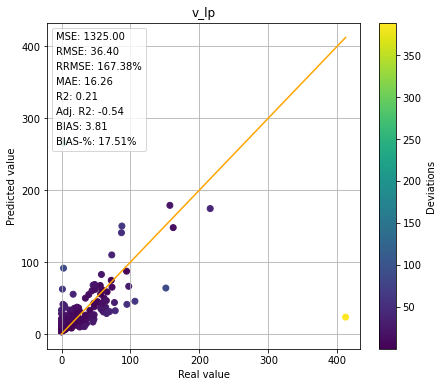

In [63]:
ens_int.plot_results(log_y=False)
plt.show()

Run test set predictions.

In [64]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,21.511379,102.035858,5.282456,25.056505,13.582648,0.596191
1,0,22.116110,104.904305,5.093486,24.160154,13.556016,0.573168
2,1,21.042124,99.810013,4.334646,20.560715,13.451874,0.613616
3,2,23.692905,112.383583,5.731114,27.184645,14.936193,0.510135
4,3,21.040655,99.803047,4.338238,20.577751,13.450111,0.613670
5,4,22.602072,107.209381,6.187503,29.349451,14.550492,0.554204
6,5,20.966347,99.450584,5.545861,26.305922,13.917825,0.616394
7,6,22.388390,106.195816,4.751490,22.537947,14.012467,0.562594
8,7,23.449110,111.227180,5.368987,25.466948,14.340387,0.520165
9,8,23.174374,109.924004,6.093626,28.904163,13.975305,0.531343


In [65]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

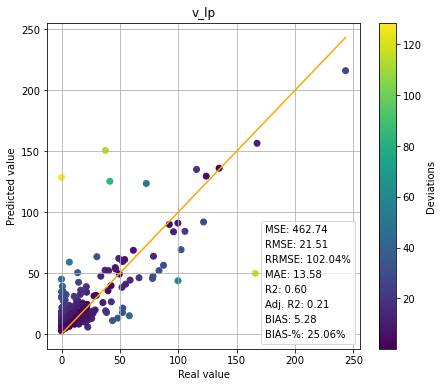

In [66]:
test_ens_interp.plot_results(log_y=False)
plt.show()

In [67]:
ensemble.export()

In [68]:
loaded_ens = load_ensemble('ensemble')

In [69]:
loaded_ens.validate(dls[1])

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,36.400539,167.381714,3.807269,17.507082,16.264874,0.209870
1,0,43.397614,199.556580,4.239144,19.492985,17.002308,-0.123091
2,1,32.909866,151.330444,2.537759,11.669456,14.900395,0.354144
3,2,41.577736,191.188187,4.603288,21.167439,17.818193,-0.030872
4,3,44.093945,202.758530,3.300354,15.176118,17.475693,-0.159420
5,4,44.815384,206.075958,5.065742,23.293959,17.783630,-0.197670
6,5,31.433651,144.542328,3.463423,15.925964,15.262568,0.410786
7,6,42.371403,194.837708,3.877888,17.831814,16.645582,-0.070604
8,7,30.883184,142.011093,2.932417,13.484224,15.089142,0.431242
9,8,44.623043,205.191513,5.399505,24.828709,17.797958,-0.187412


# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [70]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [71]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [72]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [73]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

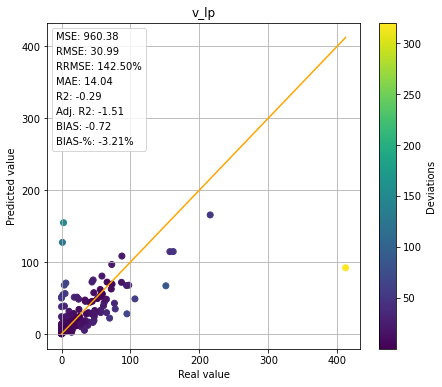

In [74]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys, log_y=False)
plt.show()

Test results

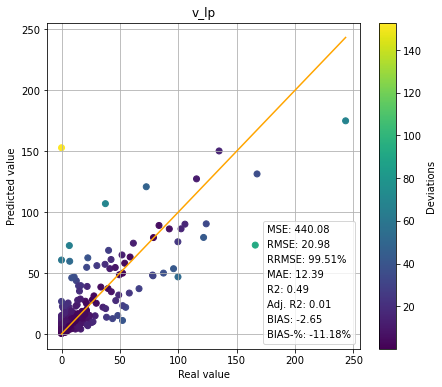

In [75]:
rf_test_preds = rf.predict(test_tb.train.xs)
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()